# Day 4: Meta-Labeling for Signal Quality

## 🎯 Learning Objectives
- Understand meta-labeling concept
- Separate signal generation from signal sizing
- Improve trading strategy precision
- Reduce false positives

---

## 📚 Theory: Meta-Labeling (Marcos López de Prado)

### The Problem
Primary model generates signals, but:
- Many false positives
- All signals treated equally
- No confidence weighting

### Meta-Labeling Solution
Two-model approach:
1. **Primary Model**: Generates buy/sell signals (side)
2. **Meta Model**: Predicts if signal will be profitable (size)

### Label Construction
Given primary signal $s_t \in \{-1, 0, 1\}$ and actual return $r_{t+h}$:
$$y_{meta} = \begin{cases} 1 & \text{if } s_t \cdot r_{t+h} > 0 \text{ (signal was correct)} \\ 0 & \text{if } s_t \cdot r_{t+h} \leq 0 \text{ (signal was wrong)} \end{cases}$$

### Trading Application
$$\text{Position} = s_t \times P(y_{meta}=1|x)$$

### Why This Works
- Primary model focuses on **direction** (recall)
- Meta model focuses on **confidence** (precision)
- Combined: Better risk-adjusted returns

### Pros & Cons

| Pros | Cons |
|------|------|
| Improves precision | Requires good primary model |
| Dynamic position sizing | More complex pipeline |
| Reduces false positives | Two models to maintain |
| Flexible primary model | Class imbalance in meta labels |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score)
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=7*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days for {ticker}")

📥 Downloading data...
✅ Data: 1758 days for AAPL


In [2]:
# Create features
df = pd.DataFrame(index=prices.index)
df['price'] = prices
df['return'] = returns

# Technical features
df['momentum_5'] = prices.pct_change(5)
df['momentum_10'] = prices.pct_change(10)
df['momentum_20'] = prices.pct_change(20)
df['volatility_10'] = returns.rolling(10).std()
df['volatility_20'] = returns.rolling(20).std()

# Moving averages
df['sma_5'] = prices.rolling(5).mean()
df['sma_20'] = prices.rolling(20).mean()
df['sma_50'] = prices.rolling(50).mean()
df['ma_ratio_5_20'] = df['sma_5'] / df['sma_20'] - 1
df['ma_ratio_20_50'] = df['sma_20'] / df['sma_50'] - 1

# RSI
delta = prices.diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
df['rsi'] = 100 - (100 / (1 + gain / loss))

# MACD
ema_12 = prices.ewm(span=12).mean()
ema_26 = prices.ewm(span=26).mean()
df['macd'] = ema_12 - ema_26
df['macd_signal'] = df['macd'].ewm(span=9).mean()
df['macd_hist'] = df['macd'] - df['macd_signal']

# Future return (for labeling)
df['next_return'] = returns.shift(-1)

df = df.dropna()
print(f"📊 Dataset: {len(df)} samples")

📊 Dataset: 1708 samples


In [3]:
# Primary Model: Simple Moving Average Crossover Signal
# This is a rule-based signal (could also be ML model)

def generate_primary_signal(df):
    """Generate primary signal based on MA crossover and RSI."""
    signal = np.zeros(len(df))
    
    # Long signal: Fast MA above Slow MA and RSI not overbought
    long_condition = (df['sma_5'] > df['sma_20']) & (df['rsi'] < 70)
    
    # Short signal: Fast MA below Slow MA and RSI not oversold
    short_condition = (df['sma_5'] < df['sma_20']) & (df['rsi'] > 30)
    
    signal[long_condition] = 1
    signal[short_condition] = -1
    
    return signal

df['primary_signal'] = generate_primary_signal(df)

# Analyze primary signal performance
df['signal_return'] = df['primary_signal'] * df['next_return']
df['signal_correct'] = (df['signal_return'] > 0).astype(int)

print("\n" + "="*60)
print("PRIMARY SIGNAL ANALYSIS")
print("="*60)
print(f"\nSignal Distribution:")
print(df['primary_signal'].value_counts())

# Only count when signal is not zero
active_signals = df[df['primary_signal'] != 0]
print(f"\nActive Signal Accuracy: {active_signals['signal_correct'].mean():.2%}")
print(f"Total Active Signals: {len(active_signals)}")


PRIMARY SIGNAL ANALYSIS

Signal Distribution:
primary_signal
 1.0    710
 0.0    521
-1.0    477
Name: count, dtype: int64

Active Signal Accuracy: 51.05%
Total Active Signals: 1187


In [4]:
# Create Meta-Labels
# Meta-label = 1 if primary signal was correct (profitable)
# We only create meta-labels for active signals (signal != 0)

df['meta_label'] = np.nan
df.loc[df['primary_signal'] != 0, 'meta_label'] = df.loc[df['primary_signal'] != 0, 'signal_correct']

# Filter to only active signals for meta-model training
meta_df = df[df['primary_signal'] != 0].copy()

print(f"\n📊 Meta-labeling dataset: {len(meta_df)} samples")
print(f"   Correct signals (1): {meta_df['meta_label'].sum():.0f} ({meta_df['meta_label'].mean():.1%})")
print(f"   Incorrect signals (0): {(1-meta_df['meta_label']).sum():.0f} ({1-meta_df['meta_label'].mean():.1%})")


📊 Meta-labeling dataset: 1187 samples
   Correct signals (1): 606 (51.1%)
   Incorrect signals (0): 581 (48.9%)


In [5]:
# Prepare meta-model data
feature_cols = ['momentum_5', 'momentum_10', 'momentum_20', 
                'volatility_10', 'volatility_20', 'ma_ratio_5_20',
                'ma_ratio_20_50', 'rsi', 'macd_hist']

# Add primary signal as feature (important for meta-model)
meta_df['signal_direction'] = meta_df['primary_signal']
feature_cols_meta = feature_cols + ['signal_direction']

X_meta = meta_df[feature_cols_meta]
y_meta = meta_df['meta_label']

# Time-series split
split_idx = int(len(meta_df) * 0.8)
X_train = X_meta.iloc[:split_idx]
X_test = X_meta.iloc[split_idx:]
y_train = y_meta.iloc[:split_idx]
y_test = y_meta.iloc[split_idx:]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 949, Test: 238


In [6]:
# Train Meta-Model
meta_models = {
    'Logistic': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
}

print("\n" + "="*70)
print("META-MODEL COMPARISON")
print("="*70)

meta_results = []
meta_predictions = {}
meta_probabilities = {}

for name, model in meta_models.items():
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    meta_predictions[name] = y_pred
    meta_probabilities[name] = y_proba
    
    meta_results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(meta_results)
print(results_df.to_string(index=False))


META-MODEL COMPARISON


            Model  Accuracy  Precision   Recall       F1      AUC
         Logistic  0.529412   0.510791 0.617391 0.559055 0.519618
    Random Forest  0.508403   0.494048 0.721739 0.586572 0.532838
Gradient Boosting  0.491597   0.476923 0.539130 0.506122 0.530223


In [7]:
# Compare Primary-Only vs Meta-Labeling Strategy
test_data = meta_df.iloc[split_idx:].copy()

# Strategy 1: Primary signal only (all signals equal)
test_data['primary_only_return'] = test_data['primary_signal'] * test_data['next_return']

# Strategy 2: Meta-filtered (only act when meta predicts correct)
best_meta = 'Random Forest'  # or choose based on AUC
test_data['meta_signal'] = meta_predictions[best_meta]
test_data['meta_probability'] = meta_probabilities[best_meta]

# Binary: Only trade when meta says yes
test_data['meta_filtered_return'] = test_data['primary_signal'] * test_data['meta_signal'] * test_data['next_return']

# Probability weighted: Size position by meta confidence
test_data['meta_weighted_return'] = test_data['primary_signal'] * test_data['meta_probability'] * test_data['next_return']

# Cumulative returns
test_data['primary_only_cum'] = (1 + test_data['primary_only_return']).cumprod()
test_data['meta_filtered_cum'] = (1 + test_data['meta_filtered_return']).cumprod()
test_data['meta_weighted_cum'] = (1 + test_data['meta_weighted_return']).cumprod()
test_data['buy_hold_cum'] = (1 + test_data['next_return']).cumprod()

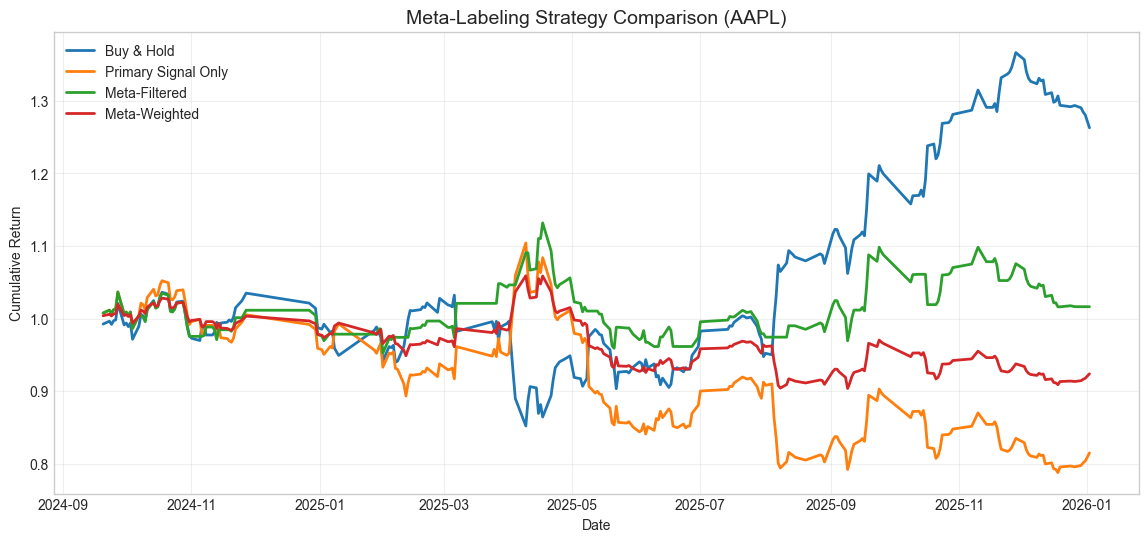

In [8]:
# Plot comparison
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(test_data.index, test_data['primary_only_cum'], label='Primary Signal Only', linewidth=2)
plt.plot(test_data.index, test_data['meta_filtered_cum'], label='Meta-Filtered', linewidth=2)
plt.plot(test_data.index, test_data['meta_weighted_cum'], label='Meta-Weighted', linewidth=2)
plt.title(f'Meta-Labeling Strategy Comparison ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# Performance metrics
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*70)
print("STRATEGY PERFORMANCE COMPARISON")
print("="*70)

strategies = [
    ('Buy & Hold', 'next_return', 'buy_hold_cum'),
    ('Primary Signal', 'primary_only_return', 'primary_only_cum'),
    ('Meta-Filtered', 'meta_filtered_return', 'meta_filtered_cum'),
    ('Meta-Weighted', 'meta_weighted_return', 'meta_weighted_cum')
]

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10} {'Trades':>8}")
print("-" * 65)

for name, ret_col, cum_col in strategies:
    total, sharpe, mdd = calc_metrics(test_data[ret_col], test_data[cum_col])
    trades = (test_data[ret_col] != 0).sum() if ret_col != 'next_return' else len(test_data)
    print(f"{name:<20} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%} {trades:>8}")


STRATEGY PERFORMANCE COMPARISON

Strategy                Total Ret     Sharpe     Max DD   Trades
-----------------------------------------------------------------
Buy & Hold                 26.29%       0.88    -17.78%      238
Primary Signal            -18.52%      -0.89    -28.66%      237
Meta-Filtered               1.63%      -0.07    -15.27%      167
Meta-Weighted              -7.62%      -0.94    -14.67%      237


In [10]:
# Analyze precision improvement
print("\n" + "="*60)
print("PRECISION ANALYSIS")
print("="*60)

# Primary signal precision
primary_correct = (test_data['primary_only_return'] > 0).sum()
primary_total = len(test_data)
print(f"\nPrimary Signal Precision: {primary_correct/primary_total:.2%}")

# Meta-filtered precision
meta_trades = test_data[test_data['meta_signal'] == 1]
meta_correct = (meta_trades['primary_only_return'] > 0).sum()
meta_total = len(meta_trades)
print(f"Meta-Filtered Precision: {meta_correct/meta_total:.2%}" if meta_total > 0 else "No trades")

# Precision improvement
if meta_total > 0:
    improvement = (meta_correct/meta_total) / (primary_correct/primary_total) - 1
    print(f"\n📈 Precision Improvement: {improvement:.1%}")
    print(f"📉 Trade Reduction: {1 - meta_total/primary_total:.1%}")


PRECISION ANALYSIS

Primary Signal Precision: 48.32%
Meta-Filtered Precision: 49.40%

📈 Precision Improvement: 2.2%
📉 Trade Reduction: 29.4%


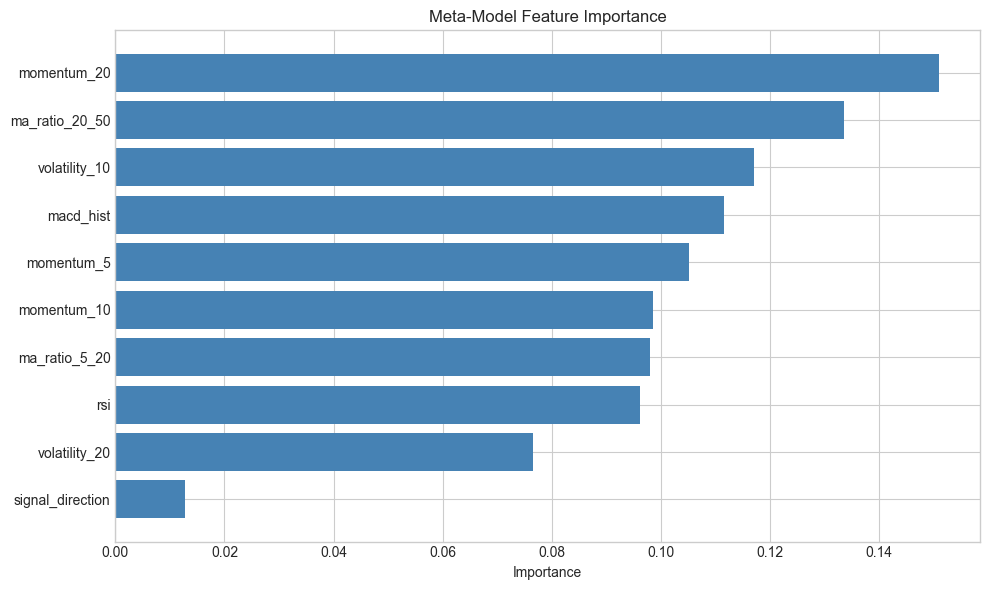

In [11]:
# Feature importance from meta-model
rf_meta = meta_models['Random Forest']
importance = pd.DataFrame({
    'Feature': feature_cols_meta,
    'Importance': rf_meta.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Meta-Model Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [12]:
# Current Meta-Labeling Signal
# Check if we have an active primary signal today
latest = df.iloc[-1]
primary_signal = latest['primary_signal']

print("\n" + "="*60)
print(f"📊 CURRENT META-LABELING SIGNAL FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\nPrimary Signal: {'📈 LONG' if primary_signal == 1 else '📉 SHORT' if primary_signal == -1 else '⏸️ NO SIGNAL'}")

if primary_signal != 0:
    # Get meta-model prediction
    latest_features = df[feature_cols].iloc[-1].values.reshape(1, -1)
    latest_features_meta = np.append(latest_features, primary_signal).reshape(1, -1)
    latest_scaled = scaler.transform(latest_features_meta)
    
    meta_pred = rf_meta.predict(latest_scaled)[0]
    meta_proba = rf_meta.predict_proba(latest_scaled)[0, 1]
    
    print(f"\nMeta-Model Prediction: {'✅ TAKE TRADE' if meta_pred == 1 else '❌ SKIP TRADE'}")
    print(f"Confidence: {meta_proba:.2%}")
    print(f"\nFinal Position: {primary_signal * meta_proba:.2f} units")
else:
    print("\n⏸️ No active primary signal - no meta-analysis needed")


📊 CURRENT META-LABELING SIGNAL FOR AAPL

Date: 2026-01-22

Primary Signal: ⏸️ NO SIGNAL

⏸️ No active primary signal - no meta-analysis needed


---

## 🏢 Real-World Applications

| Company | Meta-Labeling Use Case |
|---------|----------------------|
| Two Sigma | Signal quality filtering |
| WorldQuant | Alpha combination |
| Citadel | Execution timing |
| AQR | Factor timing |

### Key Interview Points
1. **Why meta-labeling?** - Separates direction from conviction, improves precision
2. **Primary model choice?** - Can be rule-based or ML, focus on recall
3. **Meta features?** - Include volatility, correlation, primary signal strength
4. **Position sizing?** - Use meta probability for Kelly-like sizing

---
## 📅 Tomorrow: Multi-Class Classification